In [1]:
import importlib.resources as pkg_resources
from typing import Optional

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import deep_paint

In [2]:
def split_embeddings(embeddings_df: pd.DataFrame) -> tuple:
    logits_cols = [col for col in embeddings_df.columns if col.isdigit()]
    embeddings = embeddings_df[logits_cols + ["index"]]
    metadata = embeddings_df[embeddings_df.columns.difference(logits_cols)]
    return embeddings, metadata

def plot_pca_embeddings(
    combined_embeddings: pd.DataFrame,
    label_col: str,
    color_map: dict,
    ticks: dict,
    label_map: Optional[dict] = None,
    renderer: str = "notebook"
    ):
    """
    Plot embeddings using PCA.
    
    Parameters
    ----------
    combined_embeddings: pd.DataFrame
        DataFrame of combined embeddings and metadata
    label_col: str
        Column in DataFrame that contains labels
    color_map: dict
        Dictionary that maps labels to colors
    ticks: dict
        Dictionary of tick values.
        Ex. {"xaxis": {"vals": [0, 10, 20], "dtick": 10}}, {"yaxis": {"vals": [0, 10, 20], "dtick": 10}}
    label_map: dict, optional
        Dictionary that maps label names (to display on legend)
    renderer: str, default notebook
        Plotly renderer
    """
    # Split combined embeddings
    embeddings, metadata = split_embeddings(combined_embeddings)

    # Mean center embeddings
    embeddings = embeddings - embeddings.mean()

    # Scale to unit variance
    x = StandardScaler().fit_transform(embeddings)
    x = pd.DataFrame(x, columns=embeddings.columns)

    # Principal component analysis
    pca_model = PCA(n_components=2)
    pca = pca_model.fit_transform(x)
    pca_df = pd.DataFrame(pca, columns=["PC 1", "PC 2"])
    pca_df = pd.concat([pca_df, metadata], axis=1) # merge with metadata

    # Define lower and upper percentile limits
    lower_limit = 1
    upper_limit = 99

    # Calculate lower and upper limits
    lower_pc1 = np.percentile(pca_df["PC 1"], lower_limit)
    upper_pc1 = np.percentile(pca_df["PC 1"], upper_limit)

    lower_pc2 = np.percentile(pca_df["PC 2"], lower_limit)
    upper_pc2 = np.percentile(pca_df["PC 2"], upper_limit)

    # Filter out extreme values in PC1 and PC2
    pca_df = pca_df[(pca_df["PC 1"] > lower_pc1) & (pca_df["PC 1"] < upper_pc1)]
    pca_df = pca_df[(pca_df["PC 2"] > lower_pc2) & (pca_df["PC 2"] < upper_pc2)]
    pca_df.reset_index(inplace=True, drop=True)

    # PCA Scatterplot
    fig = go.Figure()
    labels = pd.unique(pca_df[label_col])
    for label in labels:
        label_slice = pca_df[pca_df[label_col] == label]
        fig.add_trace(
            go.Scatter(
                x=label_slice["PC 1"],
                y=label_slice["PC 2"],
                mode="markers",
                name=label_map[label] if label_map is not None else label,
                marker=dict(size=10, line=dict(width=1,color="black"), color=color_map[label]),
                opacity=0.80,
            )
        )

    fig.update_layout(
        xaxis=dict(
            title=f"PC 1 ({str(repr(round(pca_model.explained_variance_ratio_[0].item() * 100, 1)))}%)",
            title_standoff=25,
            gridcolor="#E6E6E6",
            gridwidth=1,
            zerolinecolor="#E6E6E6",
            showticklabels=True,
            tickmode="array",
            tickvals=ticks["xaxis"]["vals"],
            showline=True,
            linewidth=1,
            linecolor="black",
            mirror=True,
            minor=dict(
                tickmode="linear",
                tick0=0,
                dtick=ticks["xaxis"]["dtick"],
                tickcolor="black",
                ticklen=5,
                gridcolor="#E6E6E6",
                gridwidth=1
            )

        ),
        yaxis=dict(
            title=f"PC 2 ({str(repr(round(pca_model.explained_variance_ratio_[1].item() * 100, 1)))}%)",
            title_standoff=25,
            gridcolor="#E6E6E6",
            gridwidth=1,
            zerolinecolor="#E6E6E6",
            showticklabels=True,
            tickmode="array",
            tickvals=ticks["yaxis"]["vals"],
            showline=True,
            linewidth=1,
            linecolor="black",
            mirror=True,
            minor=dict(
                tickmode="linear",
                tick0=0,
                dtick=ticks["yaxis"]["dtick"],
                tickcolor="black",
                ticklen=5,
                gridcolor="#E6E6E6",
                gridwidth=1
            )
        ),
        font=dict(
            family="Arial, sans-serif",
            size=24,
            color="black"
        ),
        legend=dict(
            x=1,
            y=1,
            title=label_col.title(),
            xanchor="right",
            yanchor="top",
            bordercolor="black",
            borderwidth=1,
            font=dict(
                family="Arial, sans-serif",
                size=14,
                color="black"
            )
        ),
        plot_bgcolor="white",
        height=700,
        width=700
    )

    fig.show(renderer=renderer)

# Binary Classifier

In [3]:
# Load embeddings
binary_embeddings_path = pkg_resources.files(deep_paint).joinpath("..", "results", "embeddings", "binary_rxrx2.csv").resolve()
binary_embeddings_combined = pd.read_csv(binary_embeddings_path)

## Embeddings by Class

In [4]:
color_map = {
    'low_conc': '#0a0fc6',
    'high_conc': '#c22020'
}
label_map = {
    'low_conc': 'Low Concentration',
    'high_conc': 'High Concentration'
}
plot_pca_embeddings(
    binary_embeddings_combined,
    label_col="class",
    color_map=color_map,
    label_map=label_map,
    ticks={
        "xaxis": {
            "vals": [0, 40, 80, 120],
            "dtick": 40
        },
        "yaxis": {
            "vals": [-25, 0, 25, 50],
            "dtick": 25
        }
    },
    renderer="jupyterlab"
)

## Embeddings by Experiment

In [5]:
color_map = {
    "HUVEC-1": "#811eba",
    "HUVEC-2": "#dfc261"
}
plot_pca_embeddings(
    binary_embeddings_combined,
    label_col="experiment",
    color_map=color_map,
    ticks={
        "xaxis": {
            "vals": [0, 40, 80, 120],
            "dtick": 40
        },
        "yaxis": {
            "vals": [-25, 0, 25, 50],
            "dtick": 25
        }
    },
    renderer="jupyterlab"
)

# Multiclass Classifier

In [6]:
# Load embeddings
multiclass_embeddings_path = pkg_resources.files(deep_paint).joinpath("..", "results", "embeddings", "multiclass_rxrx2.csv").resolve()
multiclass_embeddings_combined = pd.read_csv(multiclass_embeddings_path)

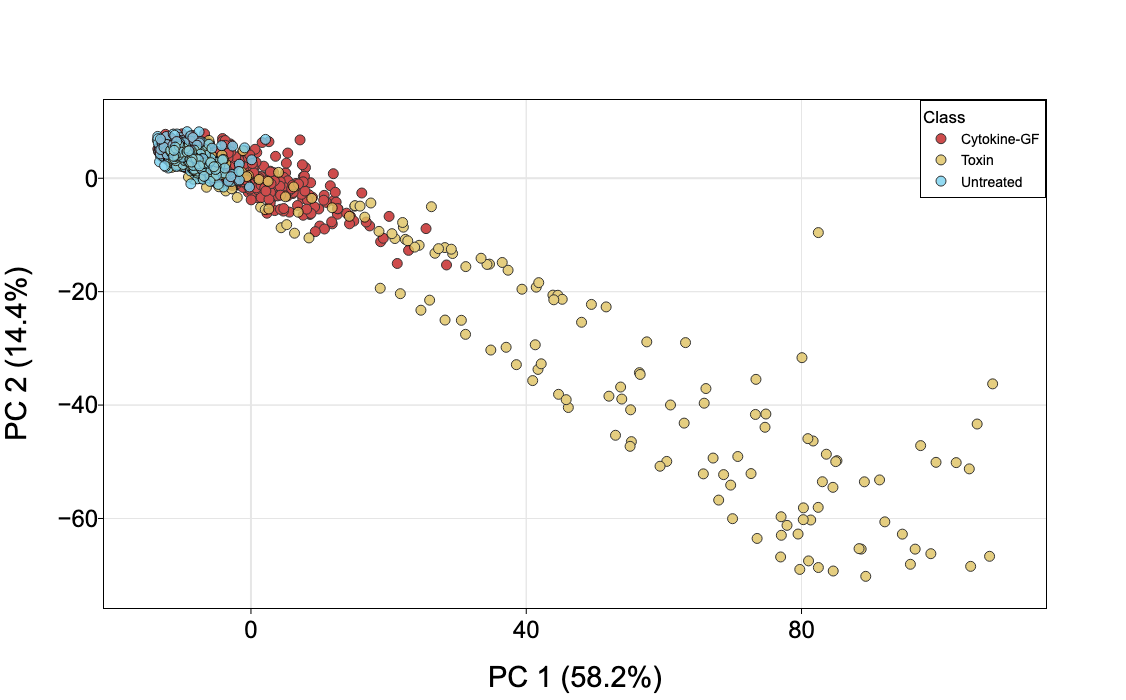

In [7]:
color_map = {
    'Cytokine-GF': '#c22020',
    'Toxin': '#dfc261',
    'Untreated': '#79d2f0'
}

plot_pca_embeddings(
    multiclass_embeddings_combined,
    label_col="class",
    color_map=color_map,
    ticks={
        "xaxis": {
            "vals": [0, 40, 80, 120],
            "dtick": 40
        },
        "yaxis": {
            "vals": [-60, -40, -20, 0],
            "dtick": 20
        }
    },
    renderer="jupyterlab"
)